In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data Preprocessing
from pandas import read_csv
from datetime import datetime

def str2time(time_str):
    return datetime.strptime(time_str, '%Y %m %d %H')

def str3time(time_str):
    return datetime.strptime(time_str, '%Y %m')

In [3]:
## combine year, month, day, hour into datetime
Shanghai = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/ShanghaiPM20100101_20151231.csv", parse_dates=[['year', 'month', 'day', 'hour']], index_col=0, date_parser=str2time)

In [4]:
dataset = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/ShanghaiPM20100101_20151231.csv")#,  parse_dates=[['year', 'month']], index_col=0, date_parser=str3time)
#dataset
dataset.dropna(axis=0,subset = ["PM_US Post"], how="any",inplace=True)
dataset.groupby(['year']).size()

year
2011      77
2012    8452
2013    8563
2014    8615
2015    8332
dtype: int64

In [5]:
Shanghai

,No,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
year_month_day_hour,,,,,,,,,,,,,
2010-01-01 00:00:00,1,4,NaN,NaN,NaN,-6.0,59.48,1026.1,1.0,cv,1.0,0.0,0.0
2010-01-01 01:00:00,2,4,NaN,NaN,NaN,-6.0,59.48,1025.1,1.0,SE,2.0,0.0,0.0
2010-01-01 02:00:00,3,4,NaN,NaN,NaN,-7.0,59.21,1025.1,0.0,SE,4.0,0.0,0.0
2010-01-01 03:00:00,4,4,NaN,NaN,NaN,-6.0,63.94,1024.0,0.0,SE,5.0,0.0,0.0
2010-01-01 04:00:00,5,4,NaN,NaN,NaN,-6.0,63.94,1023.0,0.0,SE,8.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 19:00:00,52580,4,86.0,82.0,90.0,-1.0,65.13,1035.0,5.0,NE,15.0,0.0,0.0
2015-12-31 20:00:00,52581,4,83.0,93.0,86.0,1.0,70.27,1035.0,6.0,NE,19.0,0.0,0.0
2015-12-31 21:00:00,52582,4,85.0,90.0,95.0,1.0,70.27,1036.0,6.0,NE,22.0,0.0,0.0


In [6]:
#Delet non-useful data
Shanghai.drop(['No', 'season', 'PM_Jingan', 'PM_Xuhui', 'DEWP', 'HUMI','PRES','TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec'], 
               axis=1,
              inplace=True)

Shanghai

,PM_US Post
year_month_day_hour,
2010-01-01 00:00:00,NaN
2010-01-01 01:00:00,NaN
2010-01-01 02:00:00,NaN
2010-01-01 03:00:00,NaN
2010-01-01 04:00:00,NaN
...,...
2015-12-31 19:00:00,82.0
2015-12-31 20:00:00,93.0
2015-12-31 21:00:00,90.0


In [7]:
## rename columns
Shanghai.index.name = 'date'

In [8]:
Shanghai.dropna(axis=0, how="any",inplace=True)

In [9]:
Shanghai.index = pd.to_datetime(Shanghai.index, 
                             format='%d-%m-%Y %H:%M:%S')
Shanghai = Shanghai.set_index(Shanghai.index).asfreq('H')

#print(by_hour.index)

In [10]:
# df_1 =  Shanghai city pm2.5 concentration with a duration of half a year (2015-01-01 00:00:00 ~ 2015-06-30 23:00:00)
df_1 = Shanghai[(Shanghai.index >=pd.to_datetime('20150101000000')) & (Shanghai.index <= pd.to_datetime('20150630230000'))]

len(df_1)

4344

In [11]:
# df_2 =  Shanghai city pm2.5 concentration with a duration of half a year (2014-03-28 00:00:00 ~ 2014-04-11 23:00:00)
df_2 = Shanghai[(Shanghai.index >=pd.to_datetime('20140328000000')) & (Shanghai.index <= pd.to_datetime('20140411230000'))]

len(df_2)

360

In [12]:
df_1 = df_1.set_index(df_1.index).asfreq('H')
# Show the lenth of df_1
df_1 = df_1.fillna(method='ffill')
len(df_1)

4344

In [13]:
df_2 = df_2.set_index(df_2.index).asfreq('H')
# Show the length of df_2
df_2 = df_2.fillna(method='ffill')
len(df_2)

360

In [14]:
################################################################################################################################

In [15]:
##sARIMA Forecast

In [16]:
################################################################################################################################

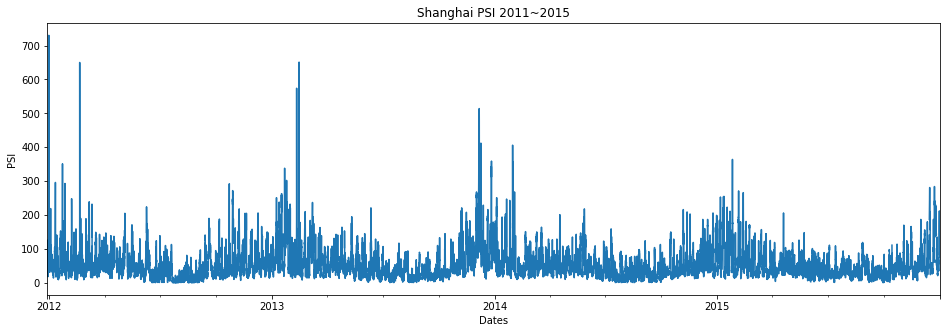

In [17]:
# Total raw dat plot
ax = Shanghai['PM_US Post'].plot(figsize = (16,5), title = "Shanghai PSI 2011~2015")
ax.set(xlabel='Dates', ylabel='PSI');

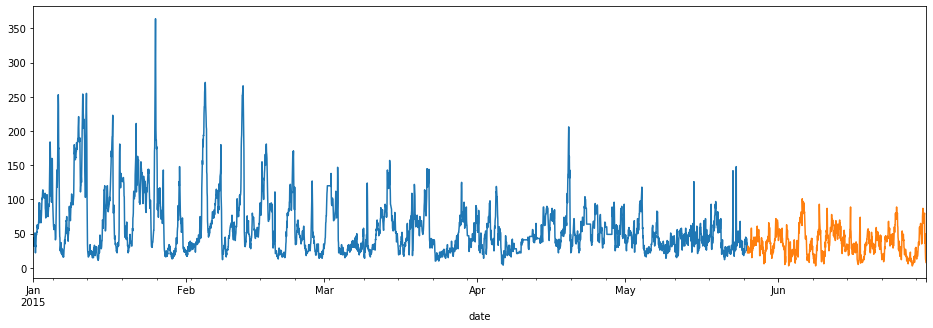

In [18]:
# Split the df_1 into train and test set by ratio 80:20
ytrain_data = df_1[:len(df_1)-869]
ytest_data = df_1[len(df_1)-869:]

ytrain_data['PM_US Post'].plot(figsize = (16,5))
ytest_data['PM_US Post'].plot()

In [19]:
from statsmodels.tsa.stattools import adfuller
# Perfprmance Dickey_Fuller Test on df_1
temp = np.array(df_1)
print('Resluts of Dickey-Fuller Test:')
t = adfuller(temp)  # ADF test
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = t[0]
output['value']['p-value'] = t[1]
output['value']['Lags Used'] = t[2]
output['value']['Number of Observations Used'] = t[3]
output['value']['Critical Value(1%)'] = t[4]['1%']
output['value']['Critical Value(5%)'] = t[4]['5%']
output['value']['Critical Value(10%)'] = t[4]['10%']
output

Resluts of Dickey-Fuller Test:


,value
Test Statistic Value,-8.83326
p-value,1.74656e-14
Lags Used,16
Number of Observations Used,4327
Critical Value(1%),-3.43186
Critical Value(5%),-2.86221
Critical Value(10%),-2.56713


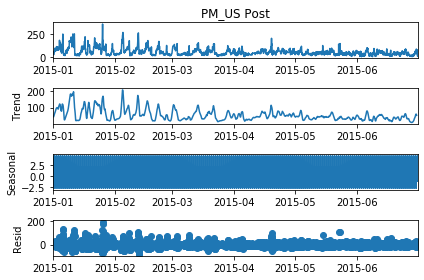

In [20]:
# Decompose the time series df_1
a = seasonal_decompose(df_1["PM_US Post"], model = "add")
a.plot();

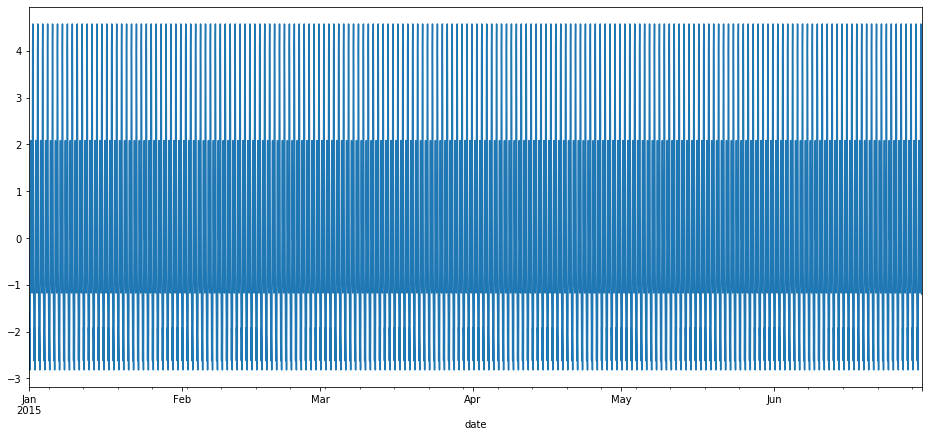

In [21]:
# Focuse on the seasonal plot of the decompose results in df_1
plt.figure(figsize = (16,7))
a.seasonal.plot();

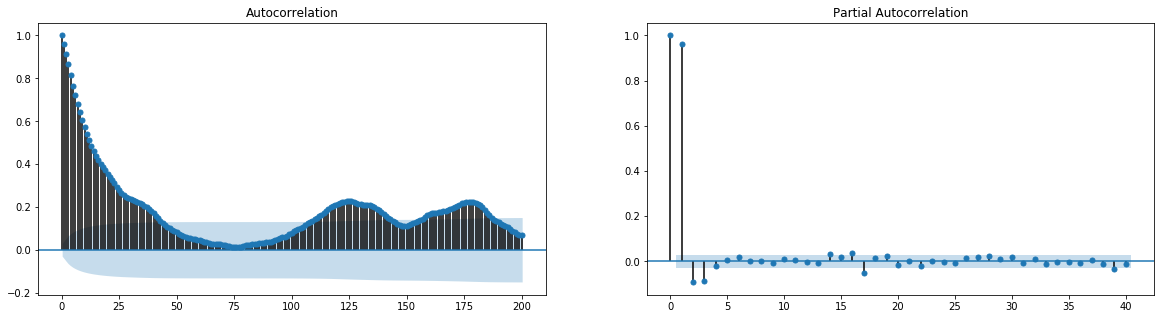

In [22]:
# Use the ACF/PACF plot to estimate the p and q order for df_1
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(df_1['PM_US Post'], lags=200, ax=axes[0], fft=False)
plot_pacf(df_1['PM_US Post'], lags=40, ax=axes[1])
plt.show()

In [38]:
# Selecting unseasonal ARIMA model for df_1 by the lowest AIC value
import statsmodels.api as sm

res = sm.tsa.stattools.arma_order_select_ic(df_1['PM_US Post'], ic=['aic']) 
print (res.aic_min_order) ## Choose ARMA(2,2) as the best model for df_1

(2, 2)


In [23]:
# Fitting our data with the ARMA(2,2) model
import statsmodels.api as sm

yarima_result = sm.tsa.ARMA(ytrain_data,(2,2)).fit()
yarima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             PM_US Post   No. Observations:                 3475
Model:                     ARMA(2, 2)   Log Likelihood              -13461.310
Method:                       css-mle   S.D. of innovations             11.640
Date:                Tue, 05 May 2020   AIC                          26934.620
Time:                        21:11:06   BIC                          26971.540
Sample:                    01-01-2015   HQIC                         26947.801
                         - 05-25-2015                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               59.7807      4.075     14.670      0.000      51.794      67.768
ar.L1.PM_US Post     1.2893      0.120     10.700      0.000       1.053       1.525
ar.L2.PM_US Post    -0.3301      0.115     -2.876      0.004      -0.555      -0.105
ma.L1.PM_US Post    -0.2329      0.120     -1.935      0.053      -0.469       0.003
ma.L2.PM_US Post     0.0788      0.023      3.389      0.001       0.033       0.124
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0673           +0.0000j            1.0673            0.0000
AR.2            2.8381           +0.0000j            2.8381            0.0000
MA.1            1.4778           -3.2417j            3.5627           -0.1819
MA.2            1.4778           +3.2417j            3.5627            0.1819
-----------------------------------------------------------------------------
"""

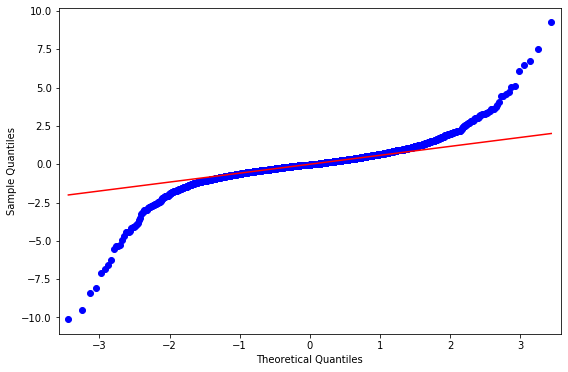

In [24]:
# Use Q-Q plot to check the plausibility of our fitted model 
from statsmodels.graphics.api import qqplot

yresid = yarima_result.resid
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(yresid, line='q', ax=ax, fit=True)
plt.show()

In [26]:
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# generate univariate observations
data = yarima_result.resid
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.830, p=0.000
Sample does not look Gaussian (reject H0)


In [47]:

# Anderson-Darling Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import anderson
# seed the random number generator
seed(1)
# generate univariate observations
data = yarima_result.resid
# normality test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 108.341
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.917, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)


In [27]:
# Do the prediciton
yarima_pred = yarima_result.predict(start = len(ytrain_data), end = len(df_1)-1, typ="levels").rename("ARIMA Predictions")
yarima_pred.head(5)

2015-05-25 19:00:00    29.617719
2015-05-25 20:00:00    30.674329
2015-05-25 21:00:00    32.211027
2015-05-25 22:00:00    33.843508
2015-05-25 23:00:00    35.440989
Freq: H, Name: ARIMA Predictions, dtype: float64

In [28]:
# Validate the result by calculating MSE and RMSE values.
yarima_rmse_error = rmse(ytest_data['PM_US Post'], yarima_pred)
yarima_mse_error = yarima_rmse_error**2
ymean_value = df_1['PM_US Post'].mean()

output=pd.DataFrame(index=['MSE Error', "RMSE Error", "Mean"],columns=['value'])
output['value']['MSE Error'] = yarima_mse_error
output['value']['RMSE Error'] = yarima_rmse_error
output['value']['Mean'] = ymean_value
output
#print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

,value
MSE Error,883.243
RMSE Error,29.7194
Mean,55.3577


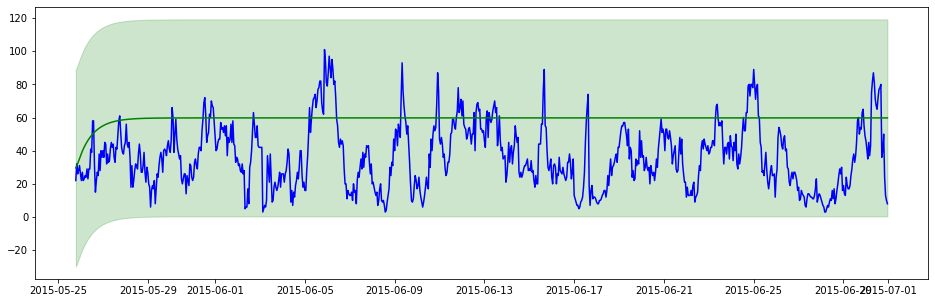

In [29]:
dyfit = 2 * np.sqrt(yarima_mse_error)
# Visualize the result with 95% confidence interval
plt.figure(figsize=(16,5))
plt.plot(ytest_data.index,ytest_data["PM_US Post"],'-', color= 'blue')
plt.plot(ytest_data.index, yarima_pred, '-', color='green')

plt.fill_between(ytest_data.index, yarima_pred - dyfit, yarima_pred + dyfit,
                 color='green', alpha=0.2)

In [ ]:
################################################################################################################################

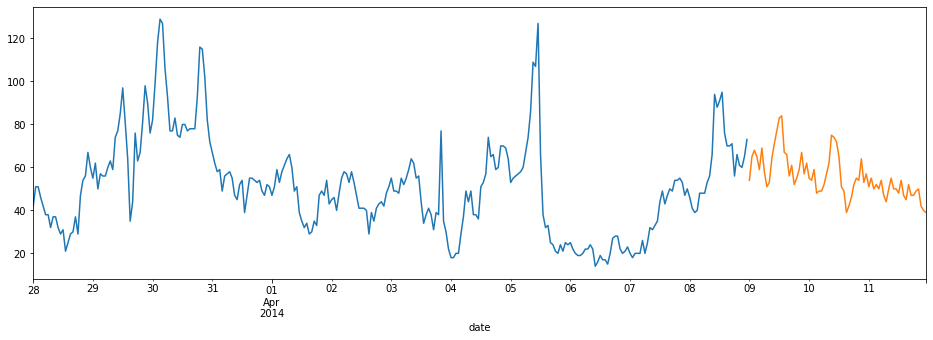

In [30]:
# Split the df_2 into train and test set by ratio 80:20
train_data = df_2[:len(df_2)-72]
test_data = df_2[len(df_2)-72:]

train_data['PM_US Post'].plot(figsize = (16,5))
test_data['PM_US Post'].plot()

In [31]:
from statsmodels.tsa.stattools import adfuller
# Perfprmance Dickey_Fuller Test on df_2
temp = np.array(df_2)
print('Resluts of Dickey-Fuller Test:')
t = adfuller(temp)  # ADF test
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = t[0]
output['value']['p-value'] = t[1]
output['value']['Lags Used'] = t[2]
output['value']['Number of Observations Used'] = t[3]
output['value']['Critical Value(1%)'] = t[4]['1%']
output['value']['Critical Value(5%)'] = t[4]['5%']
output['value']['Critical Value(10%)'] = t[4]['10%']
output

Resluts of Dickey-Fuller Test:


,value
Test Statistic Value,-4.28789
p-value,0.000466151
Lags Used,1
Number of Observations Used,358
Critical Value(1%),-3.44875
Critical Value(5%),-2.86965
Critical Value(10%),-2.57109


In [32]:
#from statsmodels.tsa.seasonal import seasonal_decompose
#result = seasonal_decompose(df["PM_US Post"], model='additive')
#print(result.trend)
#print(result.seasonal)
#print(result.resid)
#print(result.observed)

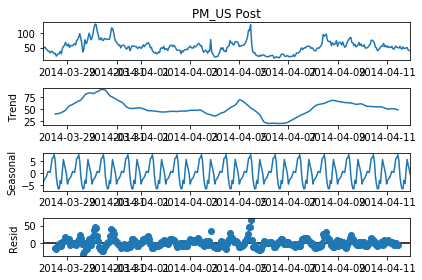

In [33]:
# Decompose the time series df_2
a = seasonal_decompose(df_2["PM_US Post"], model = "add")
a.plot();

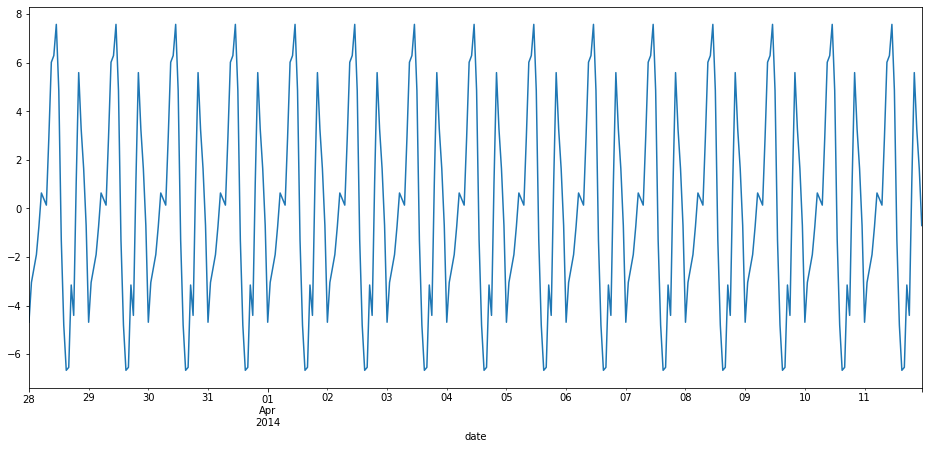

In [34]:
# Focuse on the seasonal plot of the decompose results in df_2
plt.figure(figsize = (16,7))
a.seasonal.plot();

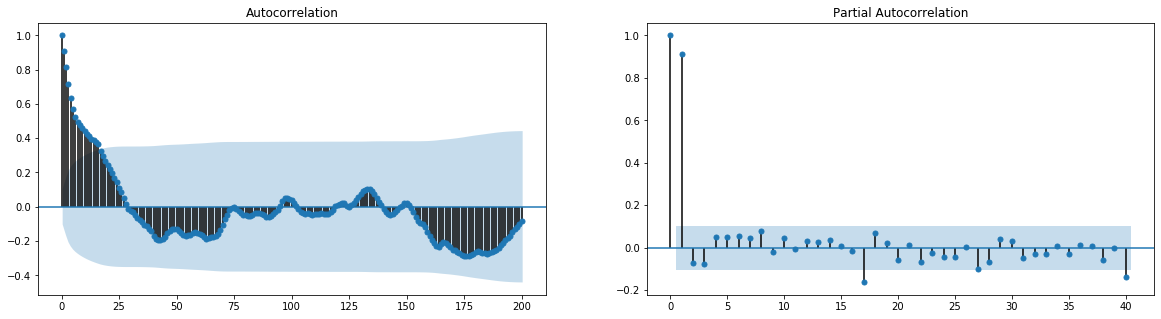

In [35]:
# Use the ACF/PACF plot to estimate the p and q order for df_2
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(df_2['PM_US Post'], lags=200, ax=axes[0], fft=False)
plot_pacf(df_2['PM_US Post'], lags=40, ax=axes[1])
plt.show()

In [37]:
# Selecting unseasonal ARIMA model for df_2 by the lowest AIC value
import statsmodels.api as sm

res = sm.tsa.stattools.arma_order_select_ic(df_2['PM_US Post'], ic=['aic']) 
print (res.aic_min_order) ## Choose ARMA(1,2) as the best model for df_2

(1, 2)


In [36]:
# Fitting our data with the ARMA(1,2) model
import statsmodels.api as sm

arima_result = sm.tsa.ARMA(train_data,(1,2)).fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             PM_US Post   No. Observations:                  288
Model:                     ARMA(1, 2)   Log Likelihood               -1041.798
Method:                       css-mle   S.D. of innovations              8.982
Date:                Tue, 05 May 2020   AIC                           2093.597
Time:                        21:13:17   BIC                           2111.912
Sample:                    03-28-2014   HQIC                          2100.936
                         - 04-08-2014                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               51.4777      5.227      9.849      0.000      41.233      61.722
ar.L1.PM_US Post     0.8795      0.034     25.862      0.000       0.813       0.946
ma.L1.PM_US Post     0.1257      0.067      1.873      0.061      -0.006       0.257
ma.L2.PM_US Post     0.0946      0.070      1.346      0.178      -0.043       0.232
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1370           +0.0000j            1.1370            0.0000
MA.1           -0.6641           -3.1821j            3.2507           -0.2827
MA.2           -0.6641           +3.1821j            3.2507            0.2827
-----------------------------------------------------------------------------
"""

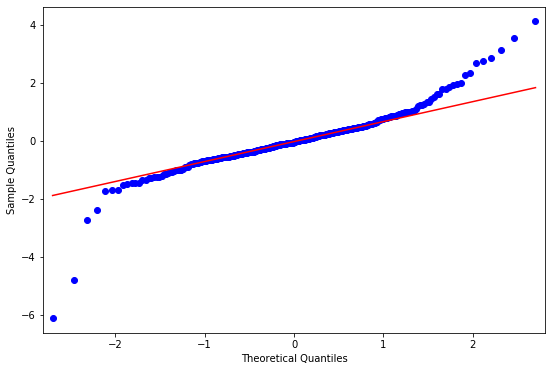

In [37]:
# Use Q-Q plot to check the plausibility of our fitted model 
from statsmodels.graphics.api import qqplot

resid = arima_result.resid
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

In [53]:

# Anderson-Darling Test
import math
from numpy.random import seed
from numpy.random import randn
from scipy.stats import anderson
# seed the random number generator
seed(1)
# generate univariate observations
data = arima_result.resid
# normality test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
        

TypeError: only size-1 arrays can be converted to Python scalars

In [38]:
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# generate univariate observations
data = arima_result.resid
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.898, p=0.000
Sample does not look Gaussian (reject H0)


In [39]:
# Do the prediciton
arima_pred = arima_result.predict(start = len(train_data), end = len(df_2)-1, typ="levels").rename("ARIMA Predictions")
arima_pred.head(5)

2014-04-09 00:00:00    72.130633
2014-04-09 01:00:00    70.482438
2014-04-09 02:00:00    68.193088
2014-04-09 03:00:00    66.179517
2014-04-09 04:00:00    64.408504
Freq: H, Name: ARIMA Predictions, dtype: float64

In [40]:
# Validate the result by calculating MSE and RMSE values.
arima_rmse_error = rmse(test_data['PM_US Post'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df_2['PM_US Post'].mean()

output=pd.DataFrame(index=['MSE Error', "RMSE Error", "Mean"],columns=['value'])
output['value']['MSE Error'] = arima_mse_error
output['value']['RMSE Error'] = arima_rmse_error
output['value']['Mean'] = mean_value
output
#print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

,value
MSE Error,88.2623
RMSE Error,9.3948
Mean,52.1056


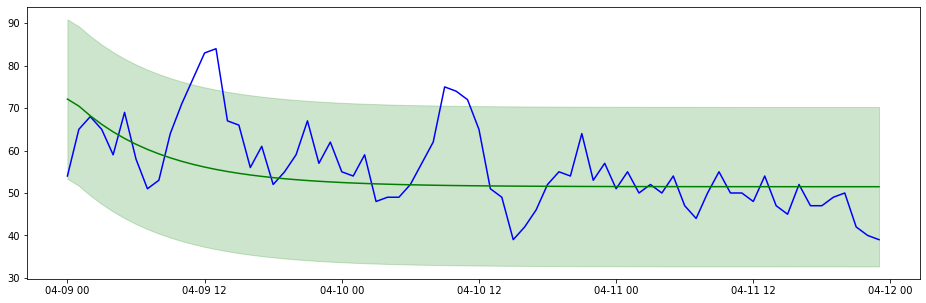

In [41]:
dfit = 2 * np.sqrt(arima_mse_error)
# Visualize the result with 95% confidence interval
plt.figure(figsize=(16,5))
plt.plot(test_data.index,test_data["PM_US Post"],'-', color= 'blue')
plt.plot(test_data.index, arima_pred, '-', color='green')

plt.fill_between(test_data.index, arima_pred - dfit, arima_pred + dfit,
                 color='green', alpha=0.2)

In [ ]:
################################################################################################################################

In [59]:
# Use the auto_arima() function to select a SARIMA model with lowest AIC.
auto_arima(train_data['PM_US Post'], start_p = 0, start_q = 0, 
                          max_p = 3, max_q = 3, m=24,
                          start_P = 0, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True).summary()

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 24) (constant=True); AIC=2454.103, BIC=2464.831, Time=3.449 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 24) (constant=True); AIC=2556.622, BIC=2563.774, Time=0.153 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 24) (constant=True); AIC=2033.409, BIC=2047.713, Time=3.529 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 24) (constant=True); AIC=2231.767, BIC=2246.071, Time=7.947 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 24) (constant=False); AIC=2555.901, BIC=2559.477, Time=0.072 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 24) (constant=True); AIC=2111.031, BIC=2121.759, Time=0.454 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 0, 24) (constant=True); AIC=2009.282, BIC=2027.162, Time=11.392 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 1, 24) (constant=True); AIC=1985.509, BIC=2006.964, Time=21.572 seconds
Nea

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  288
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 24)   Log Likelihood                -986.783
Date:                              Mon, 04 May 2020   AIC                           1983.565
Time:                                      15:21:39   BIC                           2001.445
Sample:                                           0   HQIC                          1990.750
                                              - 288                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0760      0.168     -0.453      0.650      -0.405       0.253
ar.L1          0.9183      0.023     39.933      0.000       0.873       0.963
ar.S.L24      -0.0275      0.093     -0.294      0.769      -0.210       0.156
ma.S.L24      -0.9131      0.164     -5.560      0.000      -1.235      -0.591
sigma2        87.7962      9.655      9.093      0.000      68.873     106.720
===================================================================================
Ljung-Box (Q):                       28.91   Jarque-Bera (JB):               365.66
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.48
Prob(H) (two-sided):                  0.49   Kurtosis:                         8.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
# the best arima model chosen by auto_arima() is SARIMAX((1, 0, 0)x(1, 1, [1], 24)

sarima_model = SARIMAX(train_data['PM_US Post'], order = (1, 0, 0), seasonal_order = (1, 1, [1], 24))
sarima_result = sarima_model.fit()
sarima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           PM_US Post   No. Observations:                  288
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 24)   Log Likelihood                -986.904
Date:                              Tue, 05 May 2020   AIC                           1981.807
Time:                                      21:14:07   BIC                           1996.111
Sample:                                  03-28-2014   HQIC                          1987.555
                                       - 04-08-2014                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9217      0.022     41.850      0.000       0.879       0.965
ar.S.L24      -0.0285      0.093     -0.308      0.758      -0.210       0.153
ma.S.L24      -0.9025      0.143     -6.290      0.000      -1.184      -0.621
sigma2        88.4950      8.396     10.540      0.000      72.040     104.951
===================================================================================
Ljung-Box (Q):                       29.08   Jarque-Bera (JB):               374.33
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.50
Prob(H) (two-sided):                  0.49   Kurtosis:                         8.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

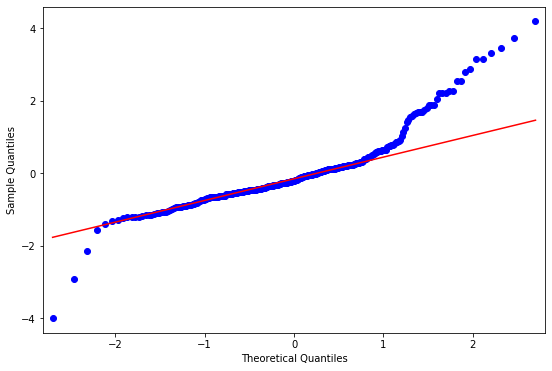

In [43]:
# Use Q-Q plot to check the plausibility of our fitted model

from statsmodels.graphics.api import qqplot

sresid = sarima_result.resid
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(sresid, line='q', ax=ax, fit=True)
plt.show()

In [44]:
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# generate univariate observations
data = sarima_result.resid
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.882, p=0.000
Sample does not look Gaussian (reject H0)


In [45]:

# Anderson-Darling Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import anderson
# seed the random number generator
seed(1)
# generate univariate observations
data = sarima_result.resid
# normality test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))


Statistic: 10.854
15.000: 0.568, data does not look normal (reject H0)
10.000: 0.647, data does not look normal (reject H0)
5.000: 0.776, data does not look normal (reject H0)
2.500: 0.906, data does not look normal (reject H0)
1.000: 1.077, data does not look normal (reject H0)


In [66]:
# Do the prediciton
sarima_pred = sarima_result.predict(start = len(train_data), end = len(df_2)-1, typ="levels").rename("SARIMA Predictions")
sarima_pred.head(5)

2014-04-09 00:00:00    68.660045
2014-04-09 01:00:00    67.737476
2014-04-09 02:00:00    66.421500
2014-04-09 03:00:00    65.954409
2014-04-09 04:00:00    66.361399
Freq: H, Name: SARIMA Predictions, dtype: float64

In [67]:
# Validate the result by calculating MSE and RMSE values.
sarima_rmse_error = rmse(test_data['PM_US Post'], sarima_pred)
sarima_mse_error = sarima_rmse_error**2
smean_value = df_2['PM_US Post'].mean()

soutput=pd.DataFrame(index=['MSE Error', "RMSE Error", "Mean"],columns=['value'])
soutput['value']['MSE Error'] = sarima_mse_error
soutput['value']['RMSE Error'] = sarima_rmse_error
soutput['value']['Mean'] = smean_value
soutput
#print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

,value
MSE Error,69.0088
RMSE Error,8.30715
Mean,52.1056


In [70]:
#import seaborn as sns
#plt.figure(figsize=(16,5))
#sns.lineplot(x= test_data.index, y=test_data["PM_US Post"])
#sns.lineplot(x=test_data.index, y = arima_pred, ci=True, data=test_data)

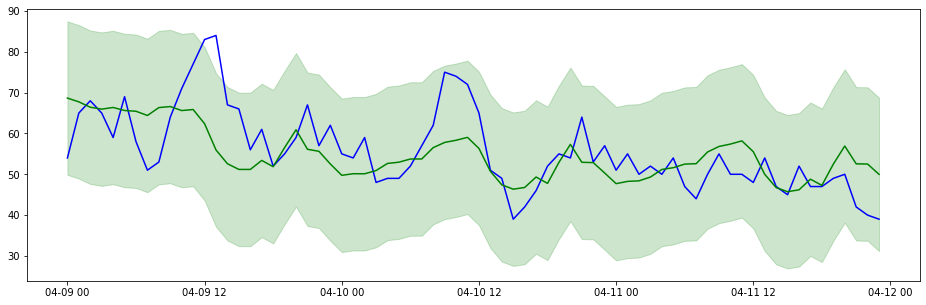

In [68]:
dfit = 2 * np.sqrt(arima_mse_error)
# Visualize the result with 95% confidence interval
plt.figure(figsize=(16,5))
plt.plot(test_data.index,test_data["PM_US Post"],'-', color= 'blue')
plt.plot(test_data.index, sarima_pred, '-', color='green')

plt.fill_between(test_data.index, sarima_pred - dfit, sarima_pred + dfit,
                 color='green', alpha=0.2)

In [101]:
test_data['ARIMA_Predictions'] = sarima_pred

In [ ]:
################################################################################################################################

In [ ]:
##LSTM Forecast

In [ ]:
################################################################################################################################

In [ ]:
#df

In [71]:
# Scale train and test data with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [73]:
#scaled_test_data

In [74]:
# Before creating LSTM model, create a Time Series Generator object.
from keras.preprocessing.sequence import TimeseriesGenerator

# Create the LSTM model for df_2
n_input = 7
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(360, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 360)               521280    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 361       
Total params: 521,641
Trainable params: 521,641
Non-trainable params: 0
_________________________________________________________________


In [75]:
lstm_model.fit_generator(generator,epochs=360)

Instructions for updating:
Use tf.cast instead.
Epoch 1/360
281/281 [==============================] - 6s 21ms/step - loss: 0.0243
Epoch 2/360
281/281 [==============================] - 6s 21ms/step - loss: 0.0158
Epoch 3/360
281/281 [==============================] - 6s 23ms/step - loss: 0.0117
Epoch 4/360
281/281 [==============================] - 7s 26ms/step - loss: 0.0109
Epoch 5/360
281/281 [==============================] - 9s 32ms/step - loss: 0.0099: 0s - l
Epoch 6/360
281/281 [==============================] - 9s 32ms/step - loss: 0.0077: 0s - loss: 0.007
Epoch 7/360
281/281 [==============================] - 10s 34ms/step - loss: 0.0091
Epoch 8/360
281/281 [==============================] - 9s 31ms/step - loss: 0.0069
Epoch 9/360
281/281 [==============================] - 9s 30ms/step - loss: 0.0069
Epoch 10/360
281/281 [==============================] - 9s 33ms/step - loss: 0.0077
Epoch 11/360
281/281 [==============================] - ETA: 0s - loss: 0.007 - 9s 34ms/step -

281/281 [==============================] - 8s 29ms/step - loss: 0.0023
Epoch 187/360
281/281 [==============================] - 9s 30ms/step - loss: 0.0022
Epoch 188/360
281/281 [==============================] - 9s 33ms/step - loss: 0.0022
Epoch 189/360
281/281 [==============================] - 10s 37ms/step - loss: 0.0023
Epoch 190/360
281/281 [==============================] - 9s 33ms/step - loss: 0.0021
Epoch 191/360
281/281 [==============================] - 9s 33ms/step - loss: 0.0021
Epoch 192/360
281/281 [==============================] - 11s 38ms/step - loss: 0.0024
Epoch 193/360
281/281 [==============================] - 8s 30ms/step - loss: 0.0024
Epoch 194/360
281/281 [==============================] - 7s 24ms/step - loss: 0.0022
Epoch 195/360
281/281 [==============================] - 7s 25ms/step - loss: 0.0024
Epoch 196/360
281/281 [==============================] - 9s 31ms/step - loss: 0.0020
Epoch 197/360
281/281 [==============================] - 10s 36ms/step - loss

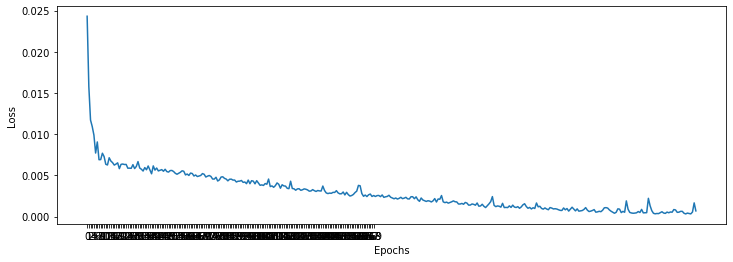

In [76]:
# View the loss(MSE) graph to visualize the accuracy increase during training
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,170,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [77]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [78]:
#lstm_predictions_scaled

In [79]:
# Rescale the output(predictions) value to true value
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
#list(lstm_predictions)

In [80]:
test_data['LSTM_Predictions'] = lstm_predictions
#test_data

In [82]:
# Validate the result by calculating MSE and RMSE values.
lstm_rmse_error = rmse(test_data['PM_US Post'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df_2['PM_US Post'].mean()

output=pd.DataFrame(index=['MSE Error', "RMSE Error", "Mean"],columns=['value'])
output['value']['MSE Error'] = lstm_mse_error
output['value']['RMSE Error'] = lstm_rmse_error
output['value']['Mean'] = mean_value
output

,value
MSE Error,231.347
RMSE Error,15.2101
Mean,52.1056


In [83]:
#test_data['PM_US Post'].plot(figsize = (16,5), legend=True)
#test_data['LSTM_Predictions'].plot(legend = True);

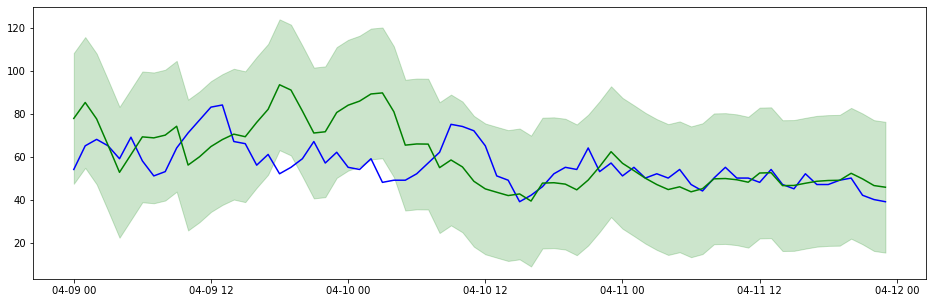

In [84]:
ldyfit = 2 * np.sqrt(lstm_mse_error)
# Visualize the result with 95% confidence interval
plt.figure(figsize=(16,5))
plt.plot(test_data.index,test_data["PM_US Post"],'-', color= 'blue')
plt.plot(test_data.index, lstm_predictions, '-', color='green')

plt.fill_between(test_data.index, test_data['LSTM_Predictions'] - ldyfit, test_data['LSTM_Predictions'] + ldyfit,
                 color='green', alpha=0.2)

In [139]:
################################################################################################################################

In [125]:
##Prophet Forecast

In [126]:
################################################################################################################################

In [86]:
# To apply the Prophet procedure 
# we need to convert our data to contain two columns named "ds" and "y", 
# representing the data time and the variables we want to predict.

df_pr = df_2.copy()
df_pr = df_2.reset_index()
df_pr.columns = ['ds','y'] # To use prophet column names should be like that
train_data_pr = df_pr.iloc[:len(df_2)-72]
test_data_pr = df_pr.iloc[len(df_2)-72:]
from fbprophet import Prophet
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=72,freq='H')
prophet_pred = m.predict(future)
prophet_pred.tail(5)

Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
355,2014-04-11 19:00:00,39.847951,14.949198,69.309841,38.801328,40.945463,2.779536,2.779536,2.779536,2.779536,2.779536,2.779536,0.0,0.0,0.0,42.627487
356,2014-04-11 20:00:00,39.813712,17.531872,72.891940,38.739649,40.946081,5.273791,5.273791,5.273791,5.273791,5.273791,5.273791,0.0,0.0,0.0,45.087503
357,2014-04-11 21:00:00,39.779472,18.719993,73.244288,38.672626,40.945744,5.460741,5.460741,5.460741,5.460741,5.460741,5.460741,0.0,0.0,0.0,45.240214
358,2014-04-11 22:00:00,39.745233,17.905867,70.108570,38.610918,40.932209,3.116297,3.116297,3.116297,3.116297,3.116297,3.116297,0.0,0.0,0.0,42.861530
359,2014-04-11 23:00:00,39.710993,10.607288,67.422156,38.558218,40.910515,-0.612411,-0.612411,-0.612411,-0.612411,-0.612411,-0.612411,0.0,0.0,0.0,39.098583


In [87]:
#df_pr

In [88]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-72:]['ds'], "Pred" : prophet_pred[-72:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "H"
prophet_pred.head(5)

,Pred
Date,
2014-04-09 00:00:00,38.366459
2014-04-09 01:00:00,37.253845
2014-04-09 02:00:00,38.335714
2014-04-09 03:00:00,40.387041
2014-04-09 04:00:00,41.922370


In [91]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values
#import seaborn as sns
#plt.figure(figsize=(16,5))
#ax = sns.lineplot(x= test_data.index, y=test_data["PM_US Post"])
#sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"]);

In [92]:
# Validate the result by calculating MSE and RMSE values.
prophet_rmse_error = rmse(test_data['PM_US Post'], test_data["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df_2['PM_US Post'].mean()

output=pd.DataFrame(index=['MSE Error', "RMSE Error", "Mean"],columns=['value'])
output['value']['MSE Error'] = prophet_mse_error
output['value']['RMSE Error'] = prophet_rmse_error
output['value']['Mean'] = mean_value
output

,value
MSE Error,308.192
RMSE Error,17.5554
Mean,52.1056


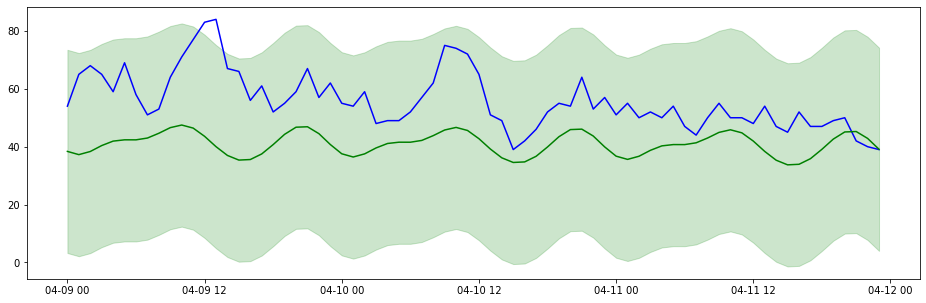

In [93]:
pdyfit = 2 * np.sqrt(prophet_mse_error)
# Visualize the result with 95% confidence interval
plt.figure(figsize=(16,5))
plt.plot(test_data.index,test_data["PM_US Post"],'-', color= 'blue')
plt.plot(test_data.index, prophet_pred, '-', color='green')

plt.fill_between(test_data.index, test_data["Prophet_Predictions"] - pdyfit, test_data["Prophet_Predictions"] + pdyfit,
                 color='green', alpha=0.2)

In [126]:
################################################################################################################################

In [ ]:
# Compare the prediction reaults from SARIMA, LSTM, Prophet

In [126]:
################################################################################################################################

In [102]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})
#plt.figure(figsize=(16,9))
#plt.plot_date(test_data.index, test_data["PM_US Post"], linestyle="-")
#plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.")
#plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--")
#plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":")
#plt.legend()
#plt.show()

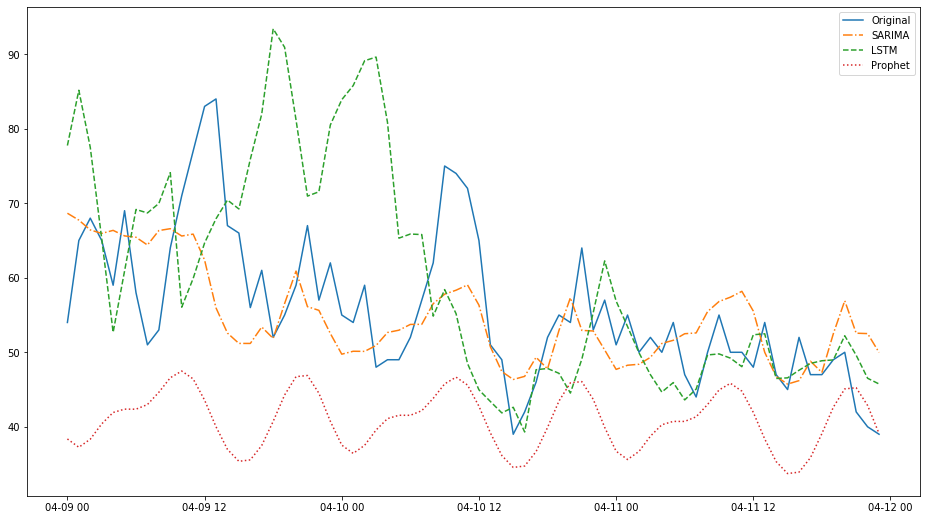

In [104]:
# Visualize the comparison result by combining 3 lineplots of the predictions together
plt.figure(figsize=(16,9))
plt.plot(test_data.index, test_data["PM_US Post"], linestyle="-",label="Original")
plt.plot(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.",label="SARIMA")
plt.plot(test_data.index, test_data["LSTM_Predictions"], linestyle="--",label="LSTM")
plt.plot(test_data.index, test_data["Prophet_Predictions"], linestyle=":",label="Prophet")
plt.legend(loc='best')
plt.show()

In [105]:
# Validate the result by calculating MSE and RMSE values.
print(f"Mean: {test_data['PM_US Post'].mean()}")
errors

Mean: 55.888888888888886


,Models,RMSE Errors,MSE Errors
0,ARIMA,9.394803,88.262325
1,LSTM,15.210084,231.346651
2,Prophet,17.555411,308.192472


In [106]:
# Show the table contains the actual data value and the prediction values from SARIMA, LSTM, Prophet models.
test_data.head(5)

,PM_US Post,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
date,,,,
2014-04-09 00:00:00,54.0,68.660045,77.747867,38.366459
2014-04-09 01:00:00,65.0,67.737476,85.163102,37.253845
2014-04-09 02:00:00,68.0,66.421500,77.498252,38.335714
2014-04-09 03:00:00,65.0,65.954409,65.248096,40.387041
2014-04-09 04:00:00,59.0,66.361399,52.676044,41.922370
